In [ ]:
import torch
from torch.autograd import Variable
from torch.distributions import normal
import torch.nn as nn
import torch.nn.functional as f

import itertool
import networkx as nx
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
# from matplotlib.patches import Circle, Rectangle

import math

%matplotlib agg

In [36]:
import torch
import torch.nn as nn
import numpy as np

class StateModel(nn.Module):
    def __init__(self):
        super(StateModel, self).__init__()

        self.inputs = 4
        hidden = 5

        self.model = nn.Sequential(
            nn.Linear(self.inputs, hidden).double(),
            nn.ReLU(),
            nn.Linear(hidden, hidden).double(),
            # nn.ReLU(),
            # nn.Linear(hidden, hidden).double(),
            nn.ReLU(),
            nn.Linear(hidden, 2).double(),
        )    

    def __call__(self, s, a):
        assert s.shape == a.shape
        assert (s.shape[1] + a.shape[1]) == self.inputs
        
        x = torch.from_numpy(np.concatenate((s, a)).reshape(s.shape[0], self.inputs)).type(torch.DoubleTensor)
        return self.model(x)
    

model = StateModel()
s =  np.array([[0., 0.], [1., 0.], [1., -1.]])
a =  np.array([[1., 0.], [0., -1.], [1., 0.]])
model(s,a)

tensor([[0.4481, 0.0945],
        [0.4573, 0.1359],
        [0.4513, 0.1092]], dtype=torch.float64, grad_fn=<AddmmBackward0>)

In [ ]:
def train(model, data, epochs=100, lr=0.1, momentum=.9):
    s,a,s_ = data['s'], data['a'], data['s_']
    
    loss = nn.MSELoss()
    optim = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    
    model.train(True)
    for _ in range(epochs):
        optim.zero_grad()
        outputs = model(s, a)

        l = loss(outputs, s_)
        
        l.backward()
        optim.step() 
        
    model.train(False)

model = StateModel()

   step                                        s    a    r  \
0   1.0  [8.715864172118636, -8.733696596118103]  2.0  1.0   
0   2.0                   [8.5982065, -9.778568]  1.0  1.0   
0   3.0                    [9.587548, -9.823143]  0.0  1.0   
0   4.0                     [8.730914, -9.45824]  0.0  1.0   
0   5.0                  [7.7406697, -9.4687805]  3.0  1.0   

                        s_  end  
0   [8.5982065, -9.778568]  0.0  
0    [9.587548, -9.823143]  0.0  
0     [8.730914, -9.45824]  0.0  
0  [7.7406697, -9.4687805]  0.0  
0   [7.4396386, -8.675775]  0.0  


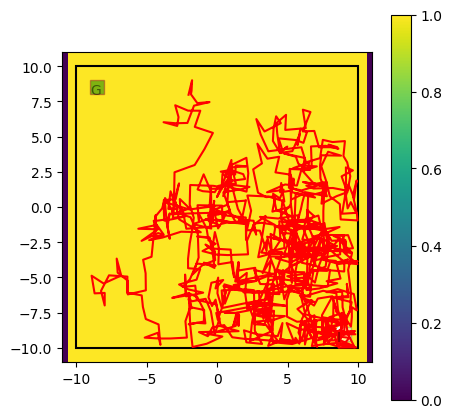

In [43]:
from src.environment import NormalMoveEnv
from src.rl import Trajectory

params = {
    'walls': [],
    'goals': [([-9.,8.],[-8.,9.])],
    'start': ([8.5,-9.5],[9.5,-8.5]),
    'beta': lambda s: (s[0]>-10. and s[0]<10.)
}

env = NormalMoveEnv(**params)
t = Trajectory(env, size=1_000)
ax = t.plot(env.plot())
ax
print(t.run.head())